# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')

In [5]:
# displaying different description of the dataset
print(azdias.info())
print(feat_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
# displaying shape of the dataset as a tuple of (rows,columns)
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# check the number of rows in the dataframe
print('number of people in the general population:',len(azdias))
print('number of features available',len(feat_info))

# check the no. of columns in the dataframe
print('number of columns in the general population dataset',len(azdias.columns))
print('number of columns in the feature summary dataset',len(feat_info.columns))



number of people in the general population: 891221
number of features available 85
number of columns in the general population dataset 85
number of columns in the feature summary dataset 4


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ZABEOTYP,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

# count of total no. of missing values in the dataframe 
print('total number of missing values in the dataset:',azdias.isnull().sum().sum())

total number of missing values in the dataset: 4896838


In [9]:
# get the digits from the missing or unknown value column
for item in range(len(feat_info)):
    unknown_data = feat_info.iloc[item]['missing_or_unknown']
    unknown_data = str(unknown_data).replace('[','').replace(']','')
    unknown_data = unknown_data.split(sep=',')
    if unknown_data != ['']:
        unknown_data = [int(i) if (i!='X' and i!='XX') else i for i in unknown_data]
        azdias = azdias.replace({feat_info.iloc[item]['attribute']: unknown_data}, np.nan)


In [10]:
# after converting the missing values

print('After conversion of the missing values, total number of unknown values in the dataset:',azdias.isnull().sum().sum())

After conversion of the missing values, total number of unknown values in the dataset: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# number of missing data in each column
print(azdias.isnull().sum())

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
# percentage of missing data in each column 

percent_missing_data = azdias.isnull().sum()/len(azdias)*100
print(percent_missing_data)

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

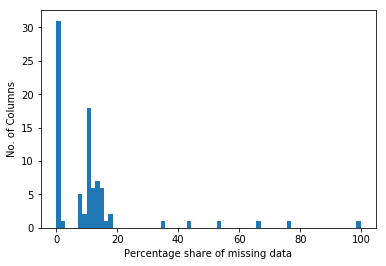

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percent_missing_data, bins = 70)
plt.ylabel('No. of Columns')
plt.xlabel('Percentage share of missing data')
plt.show()


In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outlier_columns = percent_missing_data[percent_missing_data > 20]
print(outlier_columns)

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


In [13]:
azdias = azdias.drop(outlier_columns.keys().tolist(), axis=1)

In [14]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

From the histogram, it could be observed that the columns including more than 20 percent of the total missing values in the dataset behaved as outliers for this use case. Hence, such columns have been removed for a better representation of the underlying distribution of the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?

missing_data_per_row = azdias.isnull().sum(axis=1)

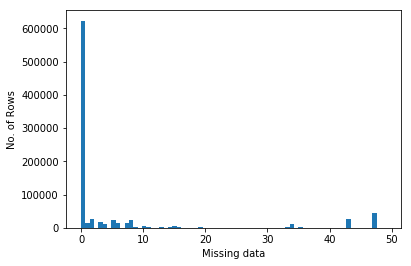

In [20]:
# plot the histogram to investigate the patterns of missing data in each row
plt.hist(missing_data_per_row, bins = 70)
plt.ylabel('No. of Rows')
plt.xlabel('Missing data')
plt.show()

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_values_lower_threshold = azdias[azdias.isnull().sum(axis=1) < 25]
missing_values_upper_threshold = azdias[azdias.isnull().sum(axis=1) >= 25]


In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_missing_cols = percent_missing_data[percent_missing_data == 0]
no_missing_cols = no_missing_cols[:7]
no_missing_column_names = no_missing_cols.keys().tolist()
print(no_missing_column_names)


['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER']


In [37]:
# function for comparison
def compare_columns(col):
    figure = plt.figure(figsize=(10,5))
    axis1 = figure.add_subplot(121)
    axis1.title.set_text('Lower Threshold of missing values')
    sns.countplot(missing_values_lower_threshold[col])
    axis2 = figure.add_subplot(122)
    axis2.title.set_text('Upper Threshold of missing values')
    sns.countplot(missing_values_upper_threshold[col])
    figure.tight_layout() 
    plt.show()

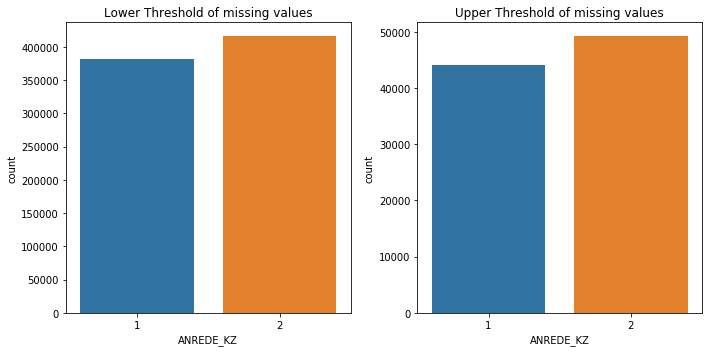

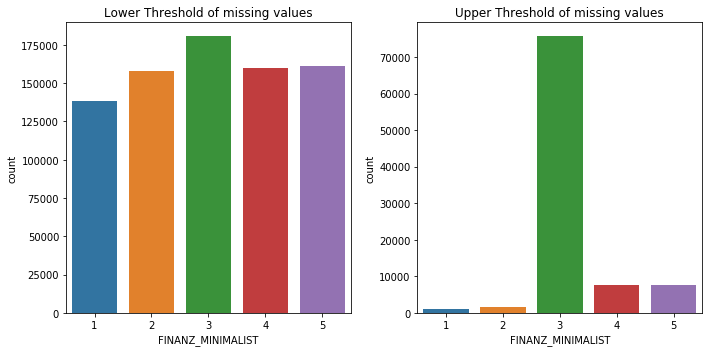

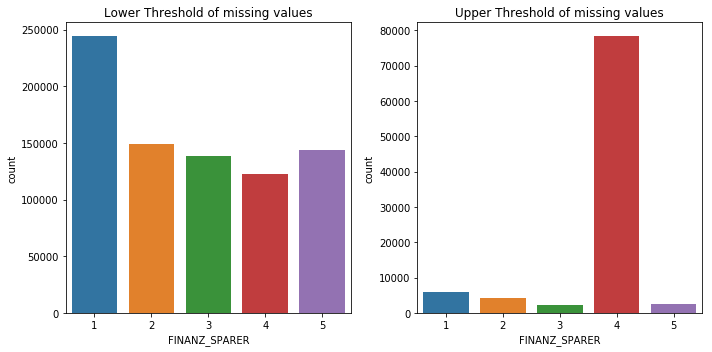

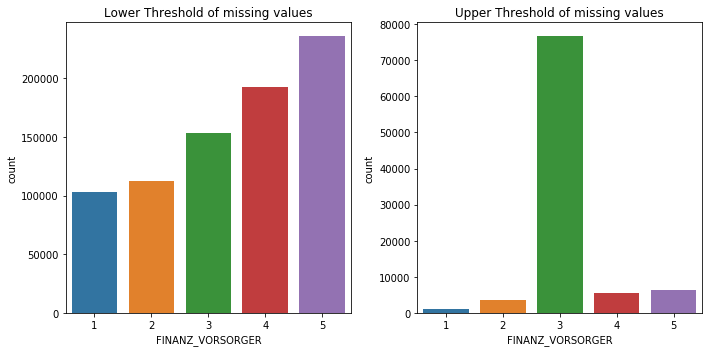

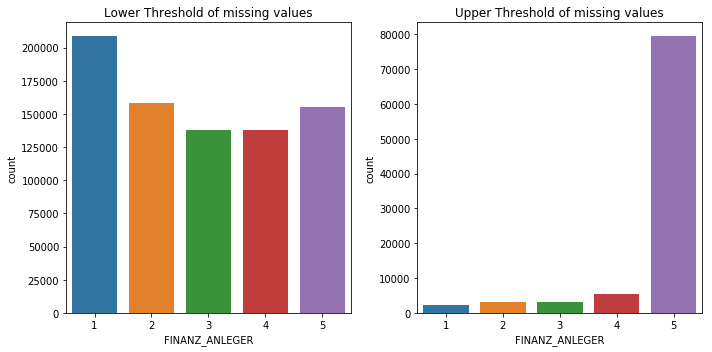

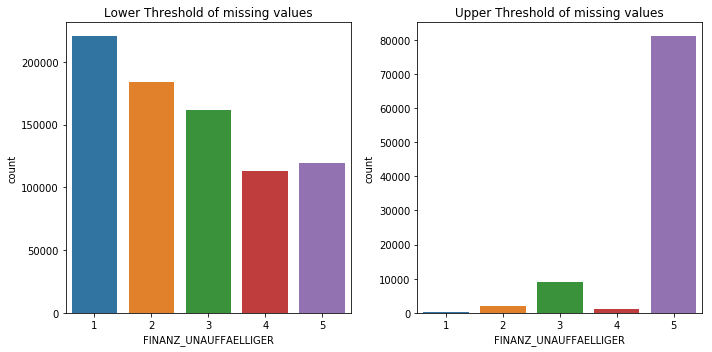

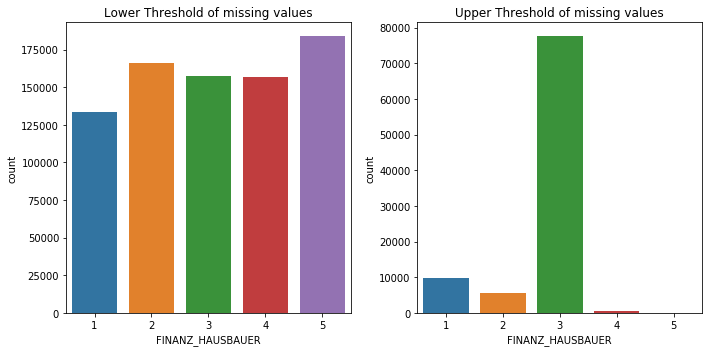

In [38]:
# implementation of the function
for column in no_missing_column_names:
    compare_columns(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

As we can see from the subplots, the distributions of features with low or no missing values look very different from the high missing value subset qualitatively in general, hence further analysis is needed for the same as to why the values are missing. For our application, we will go on with the lower threshold of of missing values for our analysis. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
features = list(missing_values_lower_threshold.columns)
features_data = feat_info[feat_info['attribute'].isin(features)]
print(features_data['type'].value_counts())


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_feat = features_data[features_data['type'] == 'categorical']['attribute']
categorical_feat.head()

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
Name: attribute, dtype: object

In [20]:
binary_categorical = []
multi_level_categorical=[]

for feat in categorical_feat:
    if (missing_values_lower_threshold[feat].nunique())==2:
        binary_categorical.append(feat)
    elif (missing_values_lower_threshold[feat].nunique())>2:
        multi_level_categorical.append(feat)

In [21]:
print('binary categorical features are: ',binary_categorical)
print('multi level categorical features are: ',multi_level_categorical)

binary categorical features are:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
multi level categorical features are:  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [22]:
print(missing_values_lower_threshold[binary_categorical].head())

   ANREDE_KZ  GREEN_AVANTGARDE  SOHO_KZ  VERS_TYP OST_WEST_KZ
1          2                 0      1.0       2.0           W
2          2                 1      0.0       1.0           W
3          2                 0      0.0       1.0           W
4          1                 0      0.0       2.0           W
5          2                 0      0.0       2.0           W


In [23]:
# see the unique values for the binary categorical OST_WEST_KZ
print(missing_values_lower_threshold['OST_WEST_KZ'].unique())

['W' 'O']


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_new = missing_values_lower_threshold.replace({'OST_WEST_KZ':{'W':0, 'O':1}})


In [25]:
azdias_new = azdias_new.drop(multi_level_categorical, axis = 1)


In [26]:
display(azdias_new.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [39]:
for categorical in multi_level_categorical:
    if categorical in azdias_new.columns:
        print('Yes')
    else:
        print('No')

No
No
No
No
No
No
No
No
No
No
No
No
No


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

1) For the binary variable with non-numeric values, I have re encoded the values into 0 and 1. For the numerical binary features, I have kept them as they are.  
2) For the multi level categorical features, I have decided to drop them as performing one-hot encoding operation would cause the dimensionality of the dataset to be much higher, which might introduce the curse of dimensionality in our analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade_variable = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_variable = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

azdias_new['DECADE'] = azdias_new['PRAEGENDE_JUGENDJAHRE']
azdias_new['MOVEMENT'] = azdias_new['PRAEGENDE_JUGENDJAHRE']

azdias_new['DECADE'].replace(decade_variable, inplace = True)
azdias_new['MOVEMENT'].replace(movement_variable, inplace = True)


In [28]:
display(azdias_new['DECADE'].head(n=5))

display(azdias_new['MOVEMENT'].head(n=5))

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: DECADE, dtype: float64

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: MOVEMENT, dtype: float64

In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth_variable = {
    '11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, 
    '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, 
    '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_variable ={
    '11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, 
    '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, 
    '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_new['WEALTH'] = azdias_new['CAMEO_INTL_2015']
azdias_new['LIFE_STAGE'] = azdias_new['CAMEO_INTL_2015']

azdias_new['WEALTH'].replace(wealth_variable, inplace = True)
azdias_new['LIFE_STAGE'].replace(life_stage_variable, inplace = True)

In [30]:
mixed_feat = features_data[features_data['type'] == 'mixed']['attribute']
print(mixed_feat)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [31]:
azdias_new = azdias_new.drop(mixed_feat, axis = 1)

In [32]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For the mixed-type features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, I re-encoded and engineered two new variables for each of the feature, namely decade and movement for the first; then wealth and life stage for the second. For the rest of the mixed-type features, I decided to drop them from the dataset. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [69]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# store azdias column names 

In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_datatype = azdias_new.dtypes
print(azdias_datatype)

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
SEMIO_KAEM                 int64
SEMIO_PFLICHT              int64
SEMIO_TRADV                int64
SOHO_KZ                  float64
VERS_TYP                 float64
ANZ_PERSONEN             float64
ANZ_TITEL                float64
HH_EINKOMMEN_SCORE       float64
          

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [33]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for item in range(len(feat_info)):
        unknown_data = feat_info.iloc[item]['missing_or_unknown']
        unknown_data = str(unknown_data).replace('[','').replace(']','')
        unknown_data = unknown_data.split(sep=',')
        if unknown_data != ['']:
            unknown_data = [int(i) if (i!='X' and i!='XX') else i for i in unknown_data]
            df = df.replace({feat_info.iloc[item]['attribute']: unknown_data}, np.nan)
    
    
    # remove selected columns and rows, ...
    df = df.drop(outlier_columns.keys().tolist(), axis=1)
    df = df[df.isnull().sum(axis=1) < 25]

    
    # select, re-encode, and engineer column values.
    df = df.replace({'OST_WEST_KZ':{'W':0, 'O':1}})
    
    df = df.drop(multi_level_categorical, axis = 1)
    
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'].replace(decade_variable, inplace = True)
    df['MOVEMENT'].replace(movement_variable, inplace = True)
    
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    df['WEALTH'].replace(wealth_variable, inplace = True)
    df['LIFE_STAGE'].replace(life_stage_variable, inplace = True)
    
    df_cleaned = df.drop(mixed_feat, axis = 1) 

    # Return the cleaned dataframe.
    return df_cleaned
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [34]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_demographic = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
azdias_cleaned = clean_data(azdias_demographic)
azdias_columns = azdias_cleaned.keys().tolist()

In [63]:
assert azdias_cleaned.shape[0] == azdias_new.shape[0], "clean_data function is not working properly, rows mismatch"
assert azdias_cleaned.shape[1] == azdias_new.shape[1], "clean_data function is not working properly, columns mismatch"
print("You passed the tests!")

You passed the tests!


In [35]:
print(azdias_cleaned.isnull().values.any())

True


In [36]:
# implement mean imputer
imputer = Imputer(missing_values = 'NaN', strategy='mean')
azdias_cleaned = imputer.fit_transform(azdias_cleaned)

# dataframe with imputed values  
azdias_clean = pd.DataFrame(azdias_cleaned, columns=azdias_columns)

In [37]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_clean_scaled = scaler.fit_transform(azdias_clean)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Firstly, I checked whether the cleaned version of the azdias dataset has any missing values or not, as there is no existence of null values in the dataset, I went on to perform feature scaling using the Standard Scaler of sklearn by fitting and transforming the azdias_cleaned dataset. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [109]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_clean_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

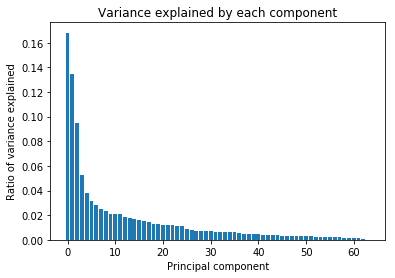

In [91]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


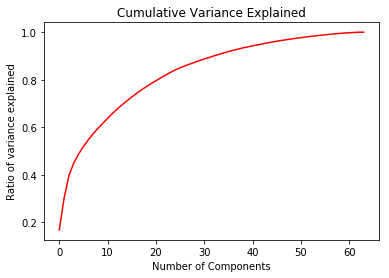

In [79]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), color = 'red')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
azdias_pca_transformed = pca.fit_transform(azdias_clean_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

By plotting the ratio of variance explained vs number of principle components plot, I have decided to retain 30 principle components as it explains almost 90 percent of the variances in the data. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [111]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(pca, i):
    dataframe = pd.DataFrame(pca.components_, columns = azdias_columns)
    return dataframe.iloc[i].sort_values(ascending = False)

In [112]:
map_weights(pca , 0)

PLZ8_ANTG3               0.227751
PLZ8_ANTG4               0.220936
WEALTH                   0.208190
HH_EINKOMMEN_SCORE       0.204420
ORTSGR_KLS9              0.198451
EWDICHTE                 0.196696
FINANZ_HAUSBAUER         0.163479
PLZ8_ANTG2               0.154943
KBA05_ANTG4              0.153921
ARBEIT                   0.144543
FINANZ_SPARER            0.142629
ANZ_HAUSHALTE_AKTIV      0.136803
RELAT_AB                 0.136385
KBA05_ANTG3              0.135984
SEMIO_PFLICHT            0.111596
SEMIO_REL                0.108644
DECADE                   0.097385
SEMIO_RAT                0.091410
SEMIO_TRADV              0.084995
SEMIO_MAT                0.075633
SEMIO_FAM                0.075072
REGIOTYP                 0.073247
FINANZ_UNAUFFAELLIGER    0.069978
SEMIO_KULT               0.069487
FINANZ_ANLEGER           0.066137
OST_WEST_KZ              0.054209
KKK                      0.044085
SEMIO_SOZ                0.042029
PLZ8_HHZ                 0.041768
SEMIO_KAEM    

In [113]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(pca , 1)


ALTERSKATEGORIE_GROB     0.261394
FINANZ_VORSORGER         0.234436
SEMIO_ERL                0.231106
SEMIO_LUST               0.184343
RETOURTYP_BK_S           0.163817
W_KEIT_KIND_HH           0.119240
FINANZ_HAUSBAUER         0.115165
SEMIO_KRIT               0.114770
SEMIO_KAEM               0.111228
ANREDE_KZ                0.089562
PLZ8_ANTG3               0.088589
EWDICHTE                 0.088080
ORTSGR_KLS9              0.086574
PLZ8_ANTG4               0.084575
WEALTH                   0.071299
SEMIO_DOM                0.070254
FINANZ_MINIMALIST        0.069423
KBA05_ANTG4              0.065778
ARBEIT                   0.065036
RELAT_AB                 0.062531
WOHNDAUER_2008           0.061776
PLZ8_ANTG2               0.061062
ANZ_HAUSHALTE_AKTIV      0.060844
HH_EINKOMMEN_SCORE       0.053506
KBA05_ANTG3              0.040264
VERS_TYP                 0.033716
ANZ_HH_TITEL             0.030449
OST_WEST_KZ              0.024717
REGIOTYP                 0.020667
PLZ8_HHZ      

In [114]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(pca , 2)

SEMIO_VERT               0.345260
SEMIO_SOZ                0.262520
SEMIO_FAM                0.250184
SEMIO_KULT               0.235625
FINANZ_MINIMALIST        0.155894
RETOURTYP_BK_S           0.108290
FINANZ_VORSORGER         0.100904
W_KEIT_KIND_HH           0.090747
ALTERSKATEGORIE_GROB     0.078669
SEMIO_REL                0.069781
SEMIO_LUST               0.064306
SEMIO_MAT                0.055620
GREEN_AVANTGARDE         0.046970
ORTSGR_KLS9              0.045931
EWDICHTE                 0.045325
MOVEMENT                 0.045030
PLZ8_ANTG4               0.044864
PLZ8_ANTG3               0.044473
ARBEIT                   0.034583
WOHNDAUER_2008           0.033070
RELAT_AB                 0.031466
PLZ8_ANTG2               0.029670
WEALTH                   0.027424
KBA05_ANTG4              0.026667
ANZ_HAUSHALTE_AKTIV      0.025315
OST_WEST_KZ              0.015216
ANZ_HH_TITEL             0.013243
VERS_TYP                 0.011769
ANZ_TITEL                0.009587
KBA05_ANTG3   

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

1) For the first principle component, PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region) and PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region) are positively correlated. Whereas PLZ_ANTG1 (No. of 1-2 family houses) and MOBI_REGIO (movement patterns) are negative correlated. Hence, in the PLZ8 region, when the number of families living in a house exceeds 6, those types of houses tend to have positive correlation.
2) For the 2nd component, ALTERSKATEGORIE_GROB (Estimated age) has  positive correlation with FINANZ_VORSORGER (being financially prepared), SEMIO_ERL(event oriented personality); and with SEMIO_REL (religious personality)- negative correlation.
3) For the 3rd component, SEMIO_VERT (dreamful personality) and SEMIO_SOZ (socially minded) are positively correlated whereas ANREDE_KZ (gender) is negatively correlated with SEMIO_VERT.  

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [115]:
# Over a number of different cluster counts...
cluster_counts = [10, 11, 13, 15, 17, 19, 20]
obtained_scores = []

# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
for c in cluster_counts:
    kmeans = KMeans(n_clusters = c)
    model = kmeans.fit(azdias_pca_transformed)
    score = np.abs(model.score(azdias_pca_transformed))
    obtained_scores.append(score)    

In [130]:
print('cluster counts experimented:', cluster_counts)
print('respective obtained scores:', obtained_scores)

cluster counts experimented: [10, 11, 13, 15, 17, 19, 20]
respective obtained scores: [27241090.589147881, 26486305.680290636, 25835156.657920446, 25164488.718472432, 24620016.068479285, 23748342.447550941, 23446294.743310399]


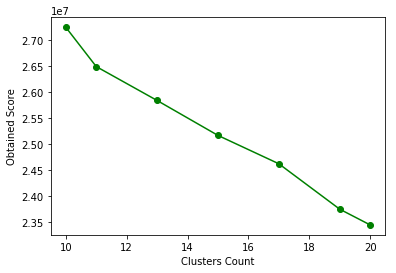

In [116]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_counts, obtained_scores, marker = 'o', color = 'green')
plt.xlabel('Clusters Count')
plt.ylabel('Obtained Score')
plt.show()


In [39]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 16)
model = kmeans.fit(azdias_pca_transformed)
cluster_pred_azdias = model.predict(azdias_pca_transformed)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

By looking into the plot between clusters count and Obtained scores, it seems like n_clusters = 16 can be considered as the elbow and hence, I decided to segment the population into 16 clusters.  

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [40]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [41]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,1.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,1.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,0.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,0.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,1.0,3.0,4.0


In [42]:
customers_clean_imputed = pd.DataFrame(imputer.transform(customers_clean))

In [43]:
customers_clean_scaled = scaler.transform(customers_clean_imputed)

In [44]:
customers_pca_transformed = pca.transform(customers_clean_scaled)

In [45]:
cluster_pred_customers = model.predict(customers_pca_transformed)

In [53]:
print(len(customers_pca_transformed))
print(len(azdias_pca_transformed))
print(len(cluster_pred_customers))
print(len(cluster_pred_azdias))

141701
797906
141701
797906


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

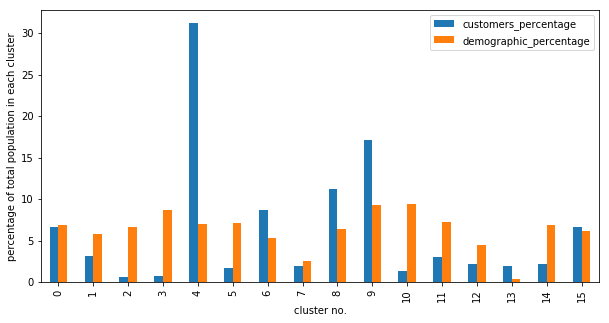

In [58]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
demographic_percentage = []
customers_percentage = []
x_axis = [c for c in range(16)]
for i in range(16):
    demographic_percentage.append((cluster_pred_azdias == i).sum()/len(cluster_pred_azdias)*100)
    customers_percentage.append((cluster_pred_customers == i).sum()/len(cluster_pred_customers)*100)


dataframe_plot = pd.DataFrame({'cluster no.' : x_axis, 'customers_percentage':customers_percentage,'demographic_percentage' : demographic_percentage})


dataframe_plot.plot(x ='cluster no.', y = ['customers_percentage','demographic_percentage'], kind='bar', figsize=(10,5))
plt.ylabel('percentage of total population in each cluster')
plt.show()


In [59]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
pca_cluster_4 = pca.inverse_transform(model.cluster_centers_[4])
overrepresented_cluster = scaler.inverse_transform(pca_cluster_4)

overrepresented_cluster = pd.Series(data = overrepresented_cluster, index = customers_clean.columns)


In [60]:
print(overrepresented_cluster)

ALTERSKATEGORIE_GROB        3.297782
ANREDE_KZ                   1.054032
FINANZ_MINIMALIST           4.854295
FINANZ_SPARER               1.626935
FINANZ_VORSORGER            4.190948
FINANZ_ANLEGER              1.510665
FINANZ_UNAUFFAELLIGER       2.171508
FINANZ_HAUSBAUER            1.887145
GREEN_AVANTGARDE            0.991675
HEALTH_TYP                  2.084033
RETOURTYP_BK_S              3.920292
SEMIO_SOZ                   4.890162
SEMIO_FAM                   4.820566
SEMIO_REL                   3.728133
SEMIO_MAT                   3.893357
SEMIO_VERT                  6.219275
SEMIO_LUST                  5.257364
SEMIO_ERL                   4.114068
SEMIO_KULT                  4.887185
SEMIO_RAT                   2.687172
SEMIO_KRIT                  3.122267
SEMIO_DOM                   3.345823
SEMIO_KAEM                  2.644867
SEMIO_PFLICHT               3.212607
SEMIO_TRADV                 3.141073
SOHO_KZ                     0.008638
VERS_TYP                    1.544547
A

In [61]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
pca_cluster_3 = pca.inverse_transform(model.cluster_centers_[3])
underrepresented_cluster = scaler.inverse_transform(pca_cluster_3)

underrepresented_cluster = pd.Series(data = underrepresented_cluster, index = customers_clean.columns)


In [62]:
print(underrepresented_cluster)

ALTERSKATEGORIE_GROB        1.518792
ANREDE_KZ                   2.013015
FINANZ_MINIMALIST           1.183490
FINANZ_SPARER               4.277566
FINANZ_VORSORGER            2.196551
FINANZ_ANLEGER              4.140335
FINANZ_UNAUFFAELLIGER       3.674371
FINANZ_HAUSBAUER            4.186276
GREEN_AVANTGARDE            0.035406
HEALTH_TYP                  2.159583
RETOURTYP_BK_S              2.529108
SEMIO_SOZ                   3.234884
SEMIO_FAM                   4.064856
SEMIO_REL                   5.654665
SEMIO_MAT                   5.199483
SEMIO_VERT                  2.181888
SEMIO_LUST                  2.827611
SEMIO_ERL                   4.113746
SEMIO_KULT                  4.317249
SEMIO_RAT                   6.429652
SEMIO_KRIT                  5.493284
SEMIO_DOM                   6.166582
SEMIO_KAEM                  6.147930
SEMIO_PFLICHT               6.500747
SEMIO_TRADV                 5.884711
SOHO_KZ                     0.007978
VERS_TYP                    1.459668
A

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

From the clustering analysis, it can be seen that - the target population for the company should be cluster 4 as it is the most overrepresented cluster in the dataset. Whereas, the customer groups that the company should not think about targeting are clusters - 2, 3, or 10.

In we try to analyze the characteristics of the population that highly differs between the overrepresented and underrepresented clusters, we can see that -

1) ALTERSKATEGORIE_GROB - the company is really popular in the age group of 45-60 years. On the other hand, comparatively younger population with less than or slightly older than 30 years of age are not frequent purchasers of the company.
2) FINANZ_SPARER - people who are high or very high money savers tend to order from the company a lot more than people who are low money savers.
3) SEMIO_REL - people with high religious affinity are more likely to be interested in the company's offerings rather than people who have comparatively less religious personality.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.